## E-commerce with RFM and Clustering

O Objetivo desse projeto é agrupar os clientes de modo para que o time de Marketing faça campanhas mais assertivas de acordo com os grupos.
Para isso Usarei os elementos da Análise RFM. Para identificar os clientes de alto valor e responder as perguntas de negócio.


# Imports

In [11]:
import re
import sweetviz as sv
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


warnings.filterwarnings( 'ignore' )

## Load Data

In [12]:
df_raw = pd.read_csv('data/ecommerce.csv',header= 0, encoding= 'unicode_escape')

In [13]:
df_raw =df_raw.drop(['Unnamed: 8'], axis=1)

In [14]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# Data Description

In [15]:
df1 = df_raw.copy()

## Rename Columns

In [16]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [17]:
import inflection

In [18]:
#Função para renomear colunas
cols_old = list(df1.columns)
snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old) )

#Rename
df1.columns = cols_new

## Data Dimensions

In [19]:
print(f'Number of Columns: {df1.shape[1]}\n')
print(f'Number of Rows: {df1.shape[0]}')



Number of Columns: 8

Number of Rows: 541909


## Data Types

In [20]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Check NA

In [21]:
df1.isna().sum()/len(df1)

invoice_no      0.000000
stock_code      0.000000
description     0.002683
quantity        0.000000
invoice_date    0.000000
unit_price      0.000000
customer_id     0.249267
country         0.000000
dtype: float64

**Há um grande numero de valores NA na coluna customer ID.**
- Não faria sentido preencher com média ou moda, vamos excluí-los.

### Drop NA

In [22]:
df1 = df1.dropna(subset=['customer_id'])

## Change dtypes

In [23]:
# invoicedate
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

#Customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [24]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## Descriptive Statistics

In [25]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributes

In [26]:
#central tendency - mean, median, 
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, 
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()) ).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()) ).T

#Merge
n = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
n.columns = ['attributes', 'min', 'max', 'range','mean', 'median', 'std','skew','kurtosis']
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


 ### Categorical Attributes

In [27]:
# check unique values of categorical features
cat_attributes.apply( lambda x: x.unique().shape[0])

invoice_no     22190
stock_code      3684
description     3896
country           37
dtype: int64

### Country

In [67]:
#purchase to countries

df1['country'].value_counts(normalize=True)

United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RSA       

In [68]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


Há mais clientes no Reino Unido (United Kingdom)com aproximadamente 4.000, seguido da Alemanha (Germany) e França (France) com 95 e 87, respectivamente.

### Invoice_no

In [69]:
# problema: A coluna invoice é composta por numeros e letras

df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

#Verificar se todos os invoices são negativos
print(f'total de invoices com letras: {len(df_letter_invoices)}')

#Verificar se todos os invoices são negativos
print(f'total de invoices com valores negativos: {len(df_letter_invoices[ df_letter_invoices["quantity"] < 0 ])}')

total de invoices com letras: 8905
total de invoices com valores negativos: 8905


# Filtering Variable

In [98]:
df2 =df1.copy()

In [99]:
#=====================Numerical Attributes=================================
#Quantity
df2 = df2.loc[df2['unit_price']>= 0.04]


#=====================Caterical Attributes=================================
df2=  df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

#Description
df2 = df2.drop(columns='description', axis=1)


#map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

#Quantity
df_return = df2.loc[df1['quantity']<0, :]
df2_purchase = df2.loc[df1['quantity']>= 0, :]


#Remove Bad User 
df2 = df2[~df2['customer_id'].isin( [16446] )]


# Feature Engeneering

In [100]:
df3 = df2.copy()

In [101]:
# Criar colunas Recency, Frequency, Monetary
# Data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)

### Gross Revenue

In [102]:
#Gross Revenue (Faturamento) - Quantity * price
df2_purchase[ 'gross_revenue'] = df2_purchase['quantity'] * df2_purchase['unit_price']

#Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

### Recency - days since the last purchase

In [103]:
# Recency - Last day purchase
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

### Quantity of Purchases by Customer


In [104]:
# Qty of invoice no per customer
df_invoice_no = df2_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns = {'invoice_no': 'qty_invoice_no'})

df_ref = pd.merge(df_ref, df_invoice_no, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id        0
gross_revenue     27
recency_days      27
qty_invoice_no    27
dtype: int64

### Quantity of products (different stock codes by customer)

In [105]:
#Products number
df_freq = (df2_purchase.loc[:,['customer_id', 'stock_code']].groupby('customer_id')
                                                            .count()
                                                            .reset_index()
                                                            .rename(columns={'stock_code':'qtde_products'}))
           
df_ref =pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue     27
recency_days      27
qty_invoice_no    27
qtde_products     27
dtype: int64

### Quantity of Items Purchased by Customer

In [106]:
# Quantity of items purchased by customer
df_freq = (df2_purchase.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qty_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id        0
gross_revenue     27
recency_days      27
qty_invoice_no    27
qtde_products     27
qty_items         27
dtype: int64

### Frequency

In [107]:
df_aux = (df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .agg(max_ =('invoice_date', 'max'),
                                                                min_ =('invoice_date', 'min'),
                                                                days_ =('invoice_date', lambda x:(( x.max() - x.min()).days)+1),
                                                                buy_ =('invoice_date', 'count'))).reset_index()
#Frequency
df_aux['frequency'] =df_aux[['buy_', 'days_']].apply( lambda x: x['buy_']/ x['days_'] if x['days_'] != 0 else 0, axis=1)

#Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], how='left', on='customer_id')

### Average Ticket Value

In [108]:
# Average Ticket Value
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue     27
recency_days      27
qty_invoice_no    27
qtde_products     27
qty_items         27
frequency         27
avg_ticket        27
dtype: int64

### Number of Returns

In [109]:
#Number of Returns
df_returns = df_return[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qty_returns'} )
df_returns['qty_returns'] = df_returns['qty_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0 #customers with 0 returned items

df_ref.isna().sum()

customer_id        0
gross_revenue     27
recency_days      27
qty_invoice_no    27
qtde_products     27
qty_items         27
frequency         27
avg_ticket        27
qty_returns        0
dtype: int64

### Basket Size

In [110]:
#Basket Size - the number of products sold in a single purchase ( Quantity )
# Invoice No = Purchase = purchase
# Stock Code = Produto Único = Product
# Quantity = Item = Item

df_aux = ( df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id         0
gross_revenue      27
recency_days       27
qty_invoice_no     27
qtde_products      27
qty_items          27
frequency          27
avg_ticket         27
qty_returns         0
avg_basket_size    27
dtype: int64

### Unique Basket Size

In [111]:
#Unique Basket Size - Quantidade de produtos distintos por compra

df_aux = ( df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                0
gross_revenue             27
recency_days              27
qty_invoice_no            27
qtde_products             27
qty_items                 27
frequency                 27
avg_ticket                27
qty_returns                0
avg_basket_size           27
avg_unique_basket_size    27
dtype: int64

# EDA

In [112]:
df4 = df_ref.copy()

**O cluster deve ser coesos e separados**
**Métricas que indicam variabilidade:** 

    - Min, Max, Range (Dispersão)
    
    - Media e Mediana
    
    - Desvio padrão e Variancia
    
    - Distribuição
    
    - Coeficiente de Variação
    
    - Olhar com atenção pros outliers

## Análise Univariada
Usar o Sweetviz

In [113]:
#generate report with Pandas Profiling Report
my_report2 = sv.analyze(df4)
my_report2.show_html() 

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


- AO analisar o relatório do sweetviz observei que tem um valor muito alto. Vamos dar um zoom nesse id e ver do que se trata

### Quantity Items

In [86]:
df4.loc[df4['qty_items']==196844]

,customer_id,gross_revenue,recency_days,qty_invoice_no,qtde_products,qty_items,frequency,avg_ticket,qty_returns,avg_basket_size,avg_unique_basket_size
908,14646,279138.02,1.0,72.0,2060.0,196844.0,0.20339,135.503893,288.0,2733.944444,9.708333


In [ ]:
Esse cliente fez a compra ha 1 dia, comprou 2060 produtos m tem uma frequencia de 20

In [91]:
df3[df3['customer_id']==14646].head(20)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
37952,539491,21981,12,2016-12-18,0.29,14646,Netherlands
37953,539491,21986,12,2016-12-18,0.29,14646,Netherlands
37954,539491,22720,2,2016-12-18,4.95,14646,Netherlands
37955,539491,21931,1,2016-12-18,1.95,14646,Netherlands
37956,539491,22613,2,2016-12-18,0.85,14646,Netherlands
37957,539491,20751,1,2016-12-18,2.10,14646,Netherlands
37958,539491,21246,2,2016-12-18,4.95,14646,Netherlands
37959,539491,22960,1,2016-12-18,4.25,14646,Netherlands
37960,539491,22355,2,2016-12-18,0.85,14646,Netherlands
37961,539491,21123,2,2016-12-18,1.25,14646,Netherlands


**- Ao que aparece é um cliente recorrente que compra grandes quantidades em pequenos valores**

### AVG Ticket

O AVG tciket também demosntrou um valor discrepante.
Percebe-se que é o mesmo cliente anterior, sendo assim, a decisão é de excluir esse id, pois ele gera um outlier e distorce as informações dos dados.

In [96]:
df4[df4['avg_ticket']==56157.5]

,customer_id,gross_revenue,recency_days,qty_invoice_no,qtde_products,qty_items,frequency,avg_ticket,qty_returns,avg_basket_size,avg_unique_basket_size
2644,16446,168472.5,0.0,2.0,3.0,80997.0,0.009709,56157.5,80995.0,40498.5,1.5


### Frequency

In [119]:
df4[df4['frequency']==17]

,customer_id,gross_revenue,recency_days,qty_invoice_no,qtde_products,qty_items,frequency,avg_ticket,qty_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,297.0,1733.0,17.0,18.152222,40.0,50.970588,0.617647


In [122]:
df3[df3['customer_id']==17850].head(20)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,6,2016-11-29,3.39,17850,United Kingdom
5,536365,22752,2,2016-11-29,7.65,17850,United Kingdom
6,536365,21730,6,2016-11-29,4.25,17850,United Kingdom
7,536366,22633,6,2016-11-29,1.85,17850,United Kingdom
8,536366,22632,6,2016-11-29,1.85,17850,United Kingdom
47,536372,22632,6,2016-11-29,1.85,17850,United Kingdom


O gráfico mostra que a distribuição é afetada pelos valores extremos. Portanto, a maioria dos clientes gastou menos de 1,00 durante o periodo em análise.

### AVG Basket size

- No gráfico é possível notar que a maioria das compras foram realizadas nos últimos 100 dias
- Mas há clientes que não fazem compras ha 373 dias

In [125]:
df4[df4['avg_basket_size']==40498.5]

,customer_id,gross_revenue,recency_days,qty_invoice_no,qtde_products,qty_items,frequency,avg_ticket,qty_returns,avg_basket_size,avg_unique_basket_size


## Bivariate Analysis

- analyze a feature in relation to all others

In [133]:
cols = ['customer_id']
df = df3.drop(cols, axis = 1).copy()

In [ ]:
plt.figure( figsize = (25, 12))
sns.pairplot(df);


KeyboardInterrupt



**Notes**

    - Frequency has low variance
    - Avg ticket has low variance

In [ ]:
pd.to_csv('data/data.to_csv')

# Segmentar os Clientes

In [126]:
rfm_table = df4.copy()
rfm_table.head()

,customer_id,gross_revenue,recency_days,qty_invoice_no,qtde_products,qty_items,frequency,avg_ticket,qty_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,297.0,1733.0,17.000000,18.152222,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,171.0,1390.0,0.028302,18.904035,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,232.0,5028.0,0.040323,28.902500,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,28.0,439.0,0.017921,33.866071,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,3.0,80.0,0.073171,292.000000,22.0,26.666667,0.333333


In [127]:
df4.head()

,customer_id,gross_revenue,recency_days,qty_invoice_no,qtde_products,qty_items,frequency,avg_ticket,qty_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,297.0,1733.0,17.000000,18.152222,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,171.0,1390.0,0.028302,18.904035,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,232.0,5028.0,0.040323,28.902500,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,28.0,439.0,0.017921,33.866071,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,3.0,80.0,0.073171,292.000000,22.0,26.666667,0.333333


In [128]:
last_day = df3.invoice_date.max() + dt.timedelta(days = 1)

In [129]:
r_labels = range(5, 0, -1)
fm_labels = range(1, 6)

rfm_table["R"] = pd.qcut(rfm_table["recency_days"], 5, labels = r_labels)
rfm_table["F"] = pd.qcut(rfm_table["frequency"].rank(method = 'first'), 5, labels = fm_labels)
rfm_table["M"] = pd.qcut(rfm_table["gross_revenue"], 5, labels = fm_labels)

rfm_table.head()

,customer_id,gross_revenue,recency_days,qty_invoice_no,qtde_products,qty_items,frequency,avg_ticket,qty_returns,avg_basket_size,avg_unique_basket_size,R,F,M
0,17850,5391.21,372.0,34.0,297.0,1733.0,17.000000,18.152222,40.0,50.970588,0.617647,1,5,5
1,13047,3232.59,56.0,9.0,171.0,1390.0,0.028302,18.904035,35.0,154.444444,11.666667,3,2,5
2,12583,6705.38,2.0,15.0,232.0,5028.0,0.040323,28.902500,50.0,335.200000,7.600000,5,3,5
3,13748,948.25,95.0,5.0,28.0,439.0,0.017921,33.866071,0.0,87.800000,4.800000,2,2,4
4,15100,876.00,333.0,3.0,3.0,80.0,0.073171,292.000000,22.0,26.666667,0.333333,1,3,3


In [130]:
rfm_table["RFM_segment"] = rfm_table["R"].astype(str) + rfm_table["F"].astype(str) + rfm_table["M"].astype(str)
rfm_table["RFM_score"] = rfm_table[["R", "F", "M"]].sum(axis = 1)

rfm_table.head()


,customer_id,gross_revenue,recency_days,qty_invoice_no,qtde_products,qty_items,frequency,avg_ticket,qty_returns,avg_basket_size,avg_unique_basket_size,R,F,M,RFM_segment,RFM_score
0,17850,5391.21,372.0,34.0,297.0,1733.0,17.000000,18.152222,40.0,50.970588,0.617647,1,5,5,155,11
1,13047,3232.59,56.0,9.0,171.0,1390.0,0.028302,18.904035,35.0,154.444444,11.666667,3,2,5,325,10
2,12583,6705.38,2.0,15.0,232.0,5028.0,0.040323,28.902500,50.0,335.200000,7.600000,5,3,5,535,13
3,13748,948.25,95.0,5.0,28.0,439.0,0.017921,33.866071,0.0,87.800000,4.800000,2,2,4,224,8
4,15100,876.00,333.0,3.0,3.0,80.0,0.073171,292.000000,22.0,26.666667,0.333333,1,3,3,133,7


Campeões: Comprou recentemente, compra com frequência e gasta mais

Clientes fiéis: Compre regularmente. Responsivo a promoções.

Potencial fiel: clientes recentes com frequência média.

Clientes recentes: comprou mais recentemente, mas não com há frequência.

Promissor: compradores recentes, mas não gastaram muito.

Precisa de atenção: Recência, frequência e valores monetários acima da média. Pode não ter comprado muito recentemente.

Prestes a dormir: Recência e frequência abaixo da média. Vai perdê-los se não for reativado.

Em risco: Há algum tempo desde que eles compraram. Precisa trazê-los de volta!

Não posso perdê-los: comprava com frequência, mas não retornou por um longo tempo.

Hibernando: A última compra foi há muito tempo e possui baixo número de pedidos. Pode ser um cliente já perdido.

### Creating&Analysing RFM Segments

In [131]:
segt_map = {
            r'[1-2][1-2]': 'Hibernating',
            r'[1-2][3-4]': 'At-Risk',
            r'[1-2]5'    : 'Cannot lose them',
            r'3[1-2]'    : 'About To Sleep',
            r'33'        : 'Need Attention',
            r'[3-4][4-5]': 'Loyal Customers',
            r'41'        : 'Promising',
            r'51'        : 'New Customers',
            r'[4-5][2-3]': 'Potential Loyalists',
            r'5[4-5]'    : 'Champions'
}
rfm_table['segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str)
rfm_table['segment'] = rfm_table['segment'].replace(segt_map, regex=True)
rfm_table.sample(5)

,customer_id,gross_revenue,recency_days,qty_invoice_no,qtde_products,qty_items,frequency,avg_ticket,qty_returns,avg_basket_size,avg_unique_basket_size,R,F,M,RFM_segment,RFM_score,segment
1363,17604,309.36,217.0,2.0,63.0,169.0,0.020833,4.910476,0.0,84.50,28.500000,1,2,2,122,5,Hibernating
2494,17974,740.79,24.0,3.0,179.0,519.0,0.015306,4.138492,0.0,173.00,47.666667,4,1,3,413,8,Promising
1600,13904,332.64,37.0,2.0,26.0,332.0,0.007752,12.793846,0.0,166.00,12.000000,3,1,2,312,6,About To Sleep
2183,17781,188.02,159.0,2.0,12.0,34.0,0.021053,15.668333,0.0,17.00,6.000000,2,2,1,221,5,Hibernating
481,16558,8338.49,0.0,20.0,460.0,5377.0,0.054496,18.127152,31.0,268.85,13.200000,5,3,5,535,13,Potential Loyalists


### Visualizar o Grafico RFM


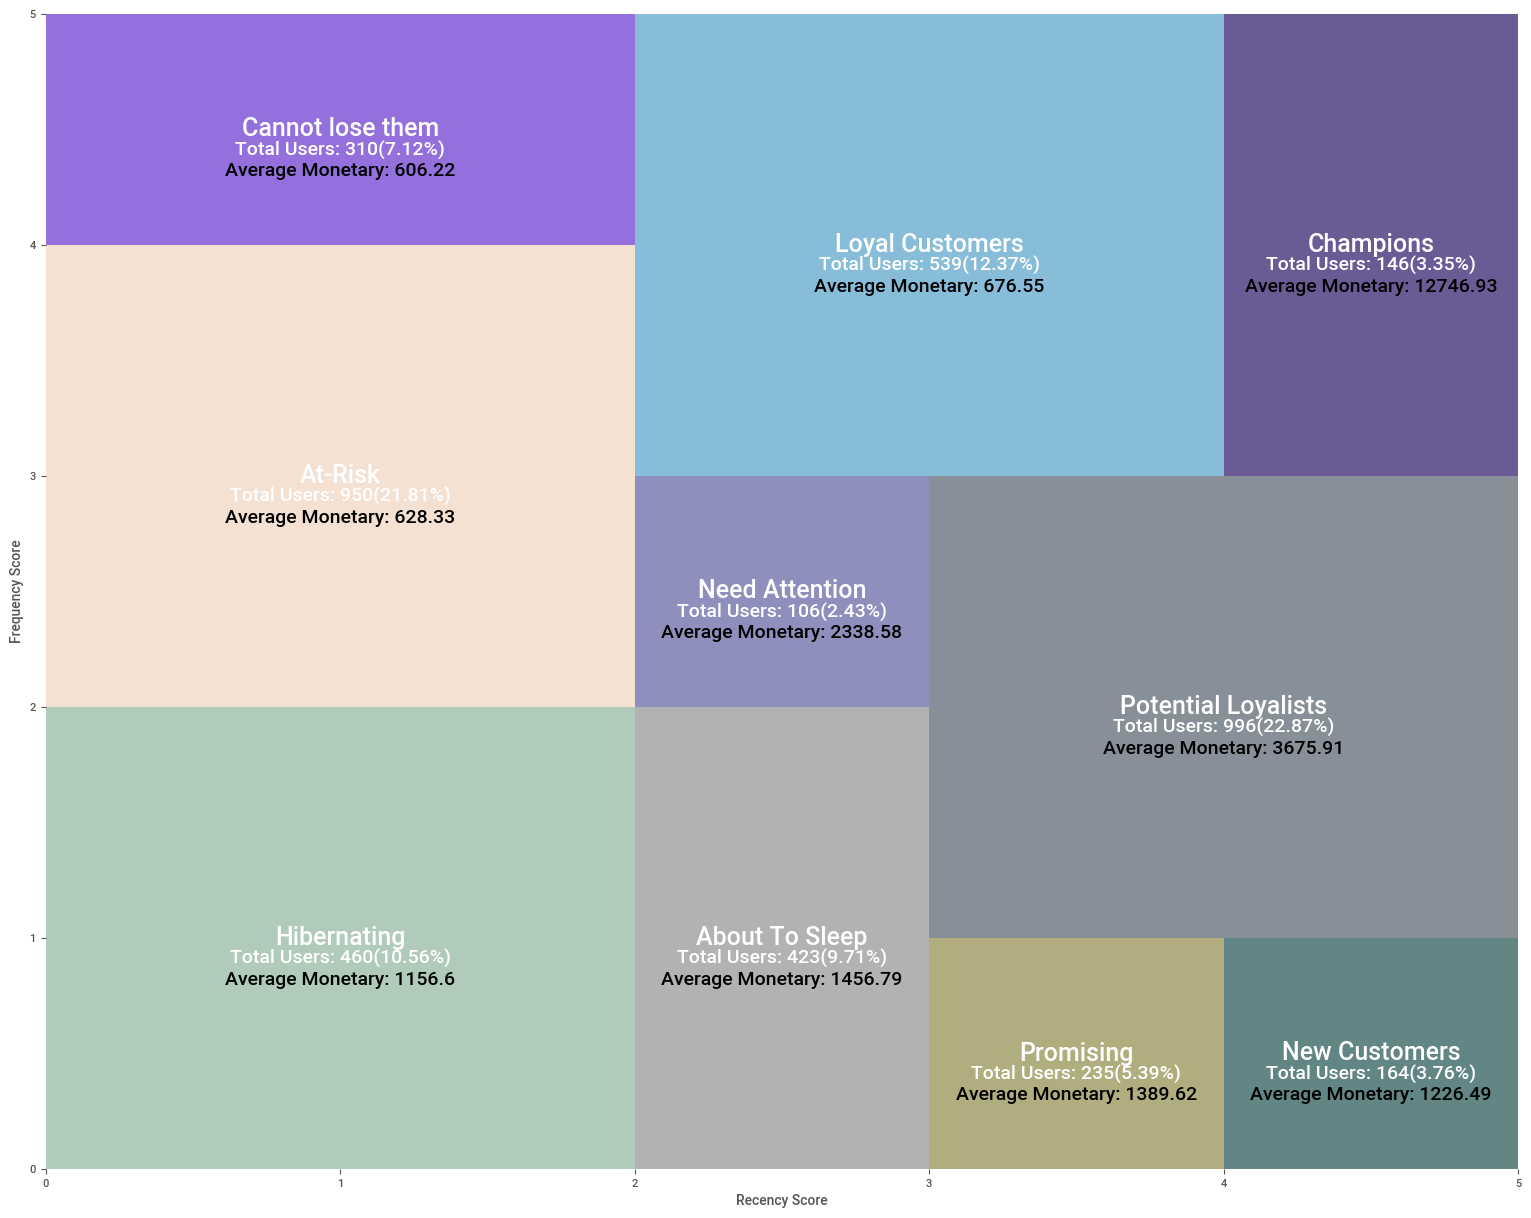

In [132]:
## Visualizing RFM Grid
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = [ "#6b5b95","#87bdd8", "#9370DB", "#f4e1d2",  "#b1cbbb", 
           "#b2b2b2", "#b2ad7f", "#618685", "#878f99", "#8F8FBD"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm_table[rfm_table.segment == key].shape[0]
    users_percentage = (rfm_table[rfm_table.segment == key].shape[0] / rfm_table.shape[0]) * 100
    avg_monetary = rfm_table[rfm_table.segment == key]["gross_revenue"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "black")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

#### Cluster Champions

**- Características:**

Quantidade: 146 clientes. 

Receita média: $ 12.746,43

Representatividade: 3,35% dos clientes